# Beta-binomial inference using PyStan & StanFitter

## PyStan and StanFitter

PyStan is typically used by importing the `pystan` module and using the `pystan.stan()` function to compile and fit a model via posterior sampling.  The PyStan test script you used to test your installation provides an example; a copy is included with this notebook as "PyStanNormNormTest.py".  It implements the normal-normal conjugate model.

Here we instead use the `StanFitter` class to access PyStan; it is defined in the `stanfitter.py` module provided with this notebook.  `StanFitter` is the only object you need from that module. You won't be modifying any `stanfitter.py` code, and you do not need to study the code, which relies on some undocumented or poorly documented parts of PyStan.  The `StanFitter` methods have docstrings, so you can use standard Python/IPython help facilities to access them.

As an example of `StanFitter` use, the "StanFitterNormalNormal.py" script included with this notebook re-implements the computations done in "PyStanNormNormTest.py", but using `StanFitter`. You don't need it for this notebook, but you may want to compare those files to see how "raw" PyStan and `StanFitter` differ.

The `stanfitter` module provides the following helpful capabilities:
* For Windows users, it **handles some Windows requirements** for you (i.e., importing `setuptools` to provide MSVC compiler identification, and disabling `multiprocessing` capability).  Windows users still have to provide a "setup.cfg" `distutils` configuration file; one is provided with this assignment.  It is named "windows_setup.cfg"; Windows users should rename it to "setup.cfg"; other users may ignore it.  **Please do not check "setup.cfg" into your Git repo**, so it does not corrupt our (non-Windows) grading environments. [**Note:** The Windows support has not yet been tested for PyStan-2.17 and later.]
* `StanFitter` **caches a Stan model** when it is compiled. Future runs of Python code that use that model will not have to execute the compilation step at runtime. This is especially useful for shortening debug time when you are revising non-Stan code in your notebooks and scripts.
* `StanFitter` provides Stan fit results via an instance of `StanFitResults`, a container class that **provides more "Pythonic" access to fit results** than Stan's native interface. In particular, all of the model parameters can be accessed as attributes of the `StanFitResults` instance; these attributes provide easy access to posterior samples and other fit results.

In [1]:
%matplotlib inline

In [2]:
# The usual imports:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from scipy import *
from scipy import stats

In [3]:
# StanFitter:
from stanfitter import StanFitter

### Beta binomial model

The following Stan code describes the beta-binomial model. This code could have been provided in a separate ".stan" file.

Helpful Wikipedia pages:
* [Binomial distribution - Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution)
* [Beta distribution - Wikipedia](https://en.wikipedia.org/wiki/Beta_distribution)

In [4]:
bb_code = """
data {
    int<lower=0> n_tot;  // total # of flips
    int<lower=0> n_heads;

    // Hyperparameters specifying the prior.
    // We could include the values in the code,
    // but providing them as "data" will let us
    // try different values without Stan having
    // to recompile the model each time.
    real a;
    real b;
}

parameters {
    real<lower=0> alpha;  // lower is not req'd but can help
}

model {
    alpha ~ beta(a, b);
    n_heads ~ binomial(n_tot, alpha);
    }
"""

Now we use `StanFitter` to compile the model, and fit it to some data (well, a *datum*).

When first run, the `StanFitter()` call will take a while, as it compiles the Stan code; progress will be logged to the terminal session where you are running the notebook server. If there is a bug in your Stan code, you may find the messages printed to the terminal helpful for debugging.

For every run, the fitting (invoked via the fitter's `sample()` method) may take a while (depending on how many samples you compute); it, too, logs progress to the terminal.

You can safely ignore **warnings** produced in either step (there may be quite a few), but **errors or exceptions** will need attention.

In [5]:
# Invoke Stan to build the model, caching the built model in the CWD to save
# time if the script is re-run without any Stan code changes.
bb_fitter = StanFitter(bb_code)

# Stan requires a dictionary providing the data.
# We'll first put the data in Python variables, so we can
# use them in Python code outside of PyStan.
a, b = 1, 1  # Bayes's flat prior
n_tot = 12
n_heads = 8
# a, b = 0.5, 0.5  # the Jeffreys prior (and reference prior)
# bb_data = {'n_tot': n_tot,  'n_heads': n_heads, 
#           'a': a, 'b' : b}
bb_data = dict(n_tot=n_tot, n_heads=n_heads, a=a, b=b)

# We can provide the data to the fitter via the set_data method,
# or we can pass the data to the sample method via a keyword
# arg:  data=bb_data.
bb_fitter.set_data(bb_data)

# Run 4 chains of 1000 iters; Stan keeps the last half of each -> 2k samples.
# The fitter returns a StanFitResults instance, whose attributes provide
# access to the fit results.
n_iter, n_chains = 1000, 4
bb_fit = bb_fitter.sample(n_iter, n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a7a9ae70a876283c9447fbd8febf5d60 NOW.


The `bb_fit` `StanFitResults` instance has attributes named for each parameter in the model (including a `log_p` attribute for the posterior density) providing access to fit results.  A print command produces a simple textual summary, including diagnostics (*be sure to check these!*) and various posterior summaries (meaningful only if the chains have converged and are mixing well).

In [6]:
print(bb_fit.alpha)
print(bb_fit.log_p)

Parameter <alpha> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 496
Mean (se), median, sd:  0.646 (0.00552),  0.652,  0.123
Central intvls:  50%: [0.563, 0.737];  95%: [0.405, 0.863]

Parameter <log_p> summary:
Convergence and mixing diagnostics:  Rhat = 1.01, ESS = 505
Mean (se), median, sd:  -8.54 (0.03),  -8.26,  0.67
Central intvls:  50%: [-8.76, -8.08];  95%: [-10.38, -8.02]



These summaries are also available as attributes of each variable; see below for a list.  For example:

In [7]:
print('Rhat and ESS for alpha:', bb_fit.alpha.Rhat, bb_fit.alpha.ess)

Rhat and ESS for alpha: 1.00432058294 496.0


Here we produce a figure with trace plots for the `alpha` parameter and `log_p`.  Colors distinguish the multiple chains. It uses the `trace` method for each variable.

/Users/loredo/anaconda/envs/cospop18/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


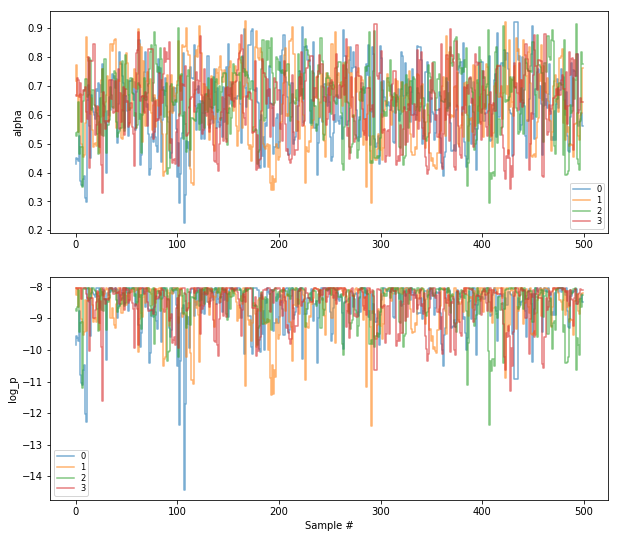

In [8]:
f=figure(figsize=(10,9))
ax=f.add_subplot(2,1,1)
bb_fit.alpha.trace(axes=ax,alpha=.6)  # without `axes`, this will make its own fig
ax.set_xlabel('')

ax=f.add_subplot(2,1,2)
bb_fit.log_p.trace(axes=ax,alpha=.6)


The `StanFitResults` instance also provides access to PyStan's default plot, a PyMC plot showing an estimated marginal PDF for each parameter (computed from the samples via a kernel density estimate), and a traceplot produced by merging all chains and shuffling the points (a somewhat questionable practice, as signs of poor convergence and mixing may be hidden).

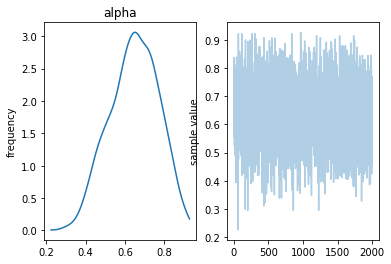

In [9]:
# Stan's default plot, showing a (marginal) PDF (via KDE) and a merged-chains
# trace plot:
fig = bb_fit.stan_plot()

Have a look at the attributes of a fit results variable:

In [10]:
dir(bb_fit.alpha)

['Rhat',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'chains',
 'clear',
 'copy',
 'ess',
 'fit',
 'fromkeys',
 'get',
 'intvl95',
 'items',
 'keys',
 'mean',
 'median',
 'name',
 'permuted',
 'pop',
 'popitem',
 'q025',
 'q25',
 'q75',
 'q975',
 'sd',
 'se_mean',
 'setdefault',
 'str',
 'subsample',
 'thinned',
 'trace',
 'update',
 'values']

StanFitter provides three collections of a variable's posterior samples. The variable's `.permuted` attribute collects all samples from all parallel chains, mixed together in a random order.  *Note that this series of samples will not display trends or correlations (i.e., signatures of initialization bias or bad mixing).*  This is a way to gather the results of all chains together into a single set, but this set is not a Markov chain sample path.

(array([   1.,    3.,    4.,   12.,   28.,   52.,   89.,  106.,  132.,
         137.,  190.,  209.,  224.,  198.,  203.,  145.,  120.,   84.,
          40.,   23.]),
 array([ 0.22553703,  0.26059223,  0.29564744,  0.33070264,  0.36575785,
         0.40081305,  0.43586825,  0.47092346,  0.50597866,  0.54103387,
         0.57608907,  0.61114428,  0.64619948,  0.68125468,  0.71630989,
         0.75136509,  0.7864203 ,  0.8214755 ,  0.85653071,  0.89158591,
         0.92664111]),
 <a list of 20 Patch objects>)

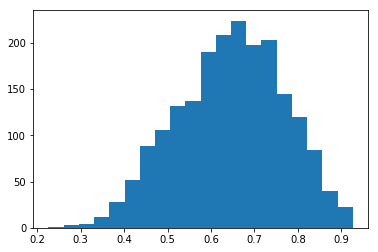

In [11]:
hist(bb_fit.alpha.permuted, bins=20)

The variable's `.chains` attribute provides access to the samples in each of the parallel chains (by index).  The `.thinned` attribute provides a single sequence of samples by joining the chains after thinning according to the smallest ESS among the parameters, which is convenient if you are using a display style (like a histogram or scatterplot) that the viewer is likely to interpret with IID sample intuition (e.g., with root-$n$ intuition about significant fluctuation sizes).

In [12]:
bb_fit.alpha.chains.shape

(500, 4)

In [13]:
bb_fit.alpha.thinned.shape

(1000,)

In [14]:
bb_fit.thinned_by  # the spacing used for thinning

2

(array([   1.,    2.,    1.,    5.,   13.,   27.,   44.,   57.,   65.,
          67.,  104.,  108.,  100.,   99.,  105.,   75.,   61.,   34.,
          19.,   13.]),
 array([ 0.22553703,  0.26059223,  0.29564744,  0.33070264,  0.36575785,
         0.40081305,  0.43586825,  0.47092346,  0.50597866,  0.54103387,
         0.57608907,  0.61114428,  0.64619948,  0.68125468,  0.71630989,
         0.75136509,  0.7864203 ,  0.8214755 ,  0.85653071,  0.89158591,
         0.92664111]),
 <a list of 20 Patch objects>)

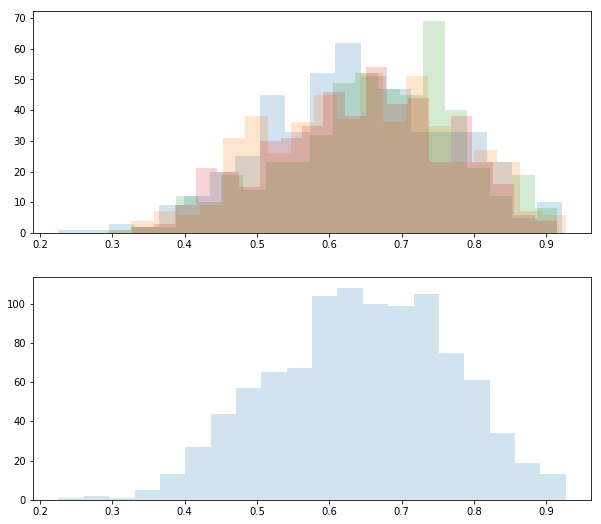

In [15]:
f=figure(figsize=(10,9))
ax=f.add_subplot(2,1,1)
for c in range(4):
    hist(bb_fit.alpha.chains[:,c], bins=20, alpha=.2)

ax=f.add_subplot(2,1,2)
hist(bb_fit.alpha.thinned, bins=20, alpha=.2)

## Exercises

* The beta-binomial model happens to be analytically tractable; we worked out the solution in the lecture.  Compare the analytical solution to a histogram of PyStan's posterior samples.  You can implement the formulas directly, or use SciPy's `scipy.stats.beta`: [scipy.stats.beta — SciPy v1.0.0 Reference Guide](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html).
* Experiment with different data and different priors.  Hyperparameters for the [Jeffreys prior (Wikipedia)](https://en.wikipedia.org/wiki/Jeffreys_prior) appear commented out in the notebook.
* Copy and paste the Stan code, and modify it to infer the expected counts parameter, `mu`, for a Poisson distribution, using a constant prior (which is a little fishy, since the range is infinite, but in this case the result may be justified with a limit argument).  The datum is again a single count, but now the parameter has a semi-infinte range.  This is another problem that is analytically tractable; the posterior is a [Gamma distribution (Wikipedia)](https://en.wikipedia.org/wiki/Gamma_distribution).
* Venture out of analytically tractable territory:  Suppose the count rate for a photon counting experiment is the sum of a signal and a background component:
$$
r = s + b.
$$
Off-source (so $r=b$), suppose you measure `n_off` counts in time `T_off`.  On-source, suppose you measure `n_on` counts in time `T_on`.  Set up a Stan model to take that data and infer $s$ (accounting for $b$ uncertainty).  This setup has a quasi-closed-form result; it can be expressed using confluent hypergeometric functions.  But those aren't very illuminating or easy to compute with!